# Unsupervised Learning
- **Principal Components Analysis**
    - A Simple Example
    - Computing the Principal Components
    - Interpreting Principal Components
    - Correspondence Analysis
- **K-Means Clustering**
    - A Simple Example
    - K-Means Algorithm
    - Interpreting the Clusters
    - Selecting the Number of Clusters
- **Hierarchical Clustering**
    - A Simple Example
    - The Dendrogram
    - The Agglomerative Algorithm
    - Measures of Dissimilarity
- **Model-Based Clustering**
    - Multivariate Normal Distribution
    - Mixtures of Normals
    - Selecting the Number of Clusters
- **Scaling and Categorical Variables**
    - Scaling the Variables
    - Dominant Variables
    - Categorical Data and Gower’s Distance
    - Problems with Clustering Mixed Data

**Aside:**

Unsupervised learning can play an important role in prediction, both for regression and classification problems. In some cases, we want to predict a category in the absence of any labeled data. For example, we might want to predict the type of vegetation in an area from a set of satellite sensory data. Since we don’t have a response variable to train a model, clustering gives us a way to identify common patterns and categorize the regions.

Clustering is an especially important tool for the “cold-start problem.” In this type of problem, such as launching a new marketing campaign or identifying potential new types of fraud or spam, we initially may not have any response to train a model. Over time, as
data is collected, we can learn more about the system and build a traditional predictive model. But clustering helps us start the learning process more quickly by identifying population segments.

Unsupervised learning is also important as a building block for regression and classification techniques. With big data, if a small subpopulation is not well represented in the overall population, the trained model may not perform well for that subpopulation. With clustering, it is possible to identify and label subpopulations. Separate models can then be fit to the different subpopulations. Alternatively, the subpopulation can be represented with its own feature,
forcing the overall model to explicitly consider subpopulation identity as a predictor.

## Principal Components Analysis

Often, variables will vary together (covary), and some of the variation in one is actually duplicated by variation in another (e.g., restaurant checks and tips). Principal
components analysis (PCA) is a technique to discover the way in which numeric variables covary

Important key terms:
- **Principal component**
- **Loadings**
- **Screeplot**

## A Simple Example

For two variables $X_1$ and $X_2$ there are two principal components $Z_i(i=1,2)$:
$$
Z_i = w_{i,1}X_1+w_{i,2}X_2
$$

The weights $(w_{i,1}, w_{i,2})$ are known as the component loadings. The first principal component, $Z_1$, is the linear combination that best explains the total variation. The second principal component, $Z_2$, is orthogonal to the first and explains as much of the remaining variation as it can. 

In [2]:
import math
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import multivariate_normal

import prince

import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib.colors import from_levels_and_colors
import seaborn as sns

%matplotlib inline

In [3]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

In [4]:
SP500_DATA_CSV = DATA / 'sp500_data.csv.gz'
SP500_SECTORS_CSV = DATA / 'sp500_sectors.csv'
LOAN_DATA_CSV = DATA / 'loan_data.csv.gz'
HOUSE_TASKS_CSV = DATA / 'housetasks.csv'

In [5]:
sp500_px = pd.read_csv(SP500_DATA_CSV, index_col=0)
oil_px = sp500_px[['XOM', 'CVX']]
print(oil_px.head())

                 XOM       CVX
1993-01-29 -0.016991  0.072921
1993-02-01  0.016991  0.102089
1993-02-02  0.084954  0.029168
1993-02-03  0.067964  0.058337
1993-02-04  0.034378  0.044272


In [6]:
pcs = PCA(n_components=2)
pcs.fit(oil_px)
loadings = pd.DataFrame(pcs.components_, columns=oil_px.columns)
print(loadings)

        XOM       CVX
0 -0.664711 -0.747101
1  0.747101 -0.664711


The weights for CVX and XOM for the first principal component are –0.747 and
–0.665, and for the second principal component they are -0.665 and 0.747. How to
interpret this? The first principal component is essentially an average of CVX and
XOM, reflecting the correlation between the two energy companies. The second principal component measures when the stock prices of CVX and XOM diverge.

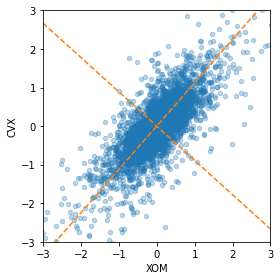

In [7]:
def abline(slope, intercept, ax):
    """Calculate coordinates of a line based on slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    return (x_vals, intercept + slope * x_vals)

ax = oil_px.plot.scatter(x='XOM', y='CVX', alpha=0.3, figsize=(4, 4))
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.plot(*abline(loadings.loc[0, 'CVX'] / loadings.loc[0, 'XOM'], 0, ax),
        '--', color='C1')
ax.plot(*abline(loadings.loc[1, 'CVX'] / loadings.loc[1, 'XOM'], 0, ax),
        '--', color='C1')

plt.tight_layout()
plt.show()

## Computing the Principal Components

The full process can be described as follows:

1. In creating the first principal component, PCA arrives at the linear combination of predictor variables that maximizes the percent of total variance explained.
2. This linear combination then becomes the first “new” predictor, $Z_1$.
3. PCA repeats this process, using the same variables with different weights, to create a second new predictor, $Z_2$. The weighting is done such that $Z_1$ and $Z_2$ are uncorrelated.
4. The process continues until you have as many new variables, or components, $Z_i$ as original variables $X_i$.
5. Choose to retain as many components as are needed to account for most of the variance.
6. The result so far is a set of weights for each component. The final step is to con‐ vert the original data into new principal component scores by applying the weights to the original values. These new scores can then be used as the reduced
set of predictor variables.

## Interpreting Principal Components

There are a couple of standard visualization displays to help you glean insight about the principal components. One such method is a screeplot to visualize the relative importance of principal components (the name derives from the resemblance of the plot to a scree slope; here, the y-axis is the eigenvalue)

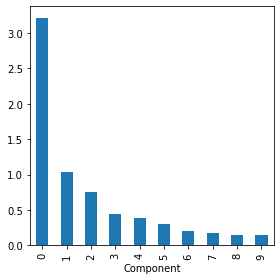

In [8]:
syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP',
        'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST'])
top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]

sp_pca = PCA()
sp_pca.fit(top_sp)

explained_variance = pd.DataFrame(sp_pca.explained_variance_)
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(4, 4))
ax.set_xlabel('Component')

plt.tight_layout()
plt.show()

In [9]:
loadings = pd.DataFrame(sp_pca.components_[0:5, :], 
                        columns=top_sp.columns)
print(loadings)

       AAPL       AXP       COP      COST      CSCO       CVX        HD  \
0 -0.300825 -0.246332 -0.261529 -0.273634 -0.064059 -0.444490 -0.207983   
1 -0.505116 -0.139426  0.174212 -0.416307 -0.031939  0.289373 -0.278002   
2 -0.786730  0.135458 -0.002367  0.465862 -0.007524  0.082374  0.166320   
3 -0.120586  0.061814 -0.206026  0.092596  0.003904 -0.577665  0.162814   
4  0.111576 -0.596666 -0.005813  0.555529 -0.039860  0.109016 -0.185488   

       INTC       JPM      MSFT       SLB       TGT       USB       WFC  \
0 -0.076956 -0.196397 -0.105012 -0.481786 -0.148833 -0.116421 -0.145684   
1 -0.033898 -0.040723 -0.053954  0.472494 -0.228123 -0.054796 -0.047427   
2 -0.003518  0.062261  0.016248 -0.194822  0.160833  0.048976  0.041932   
3 -0.001605  0.057687 -0.012558  0.680914  0.109895  0.016752  0.018614   
4 -0.072047 -0.385160 -0.077135  0.181332 -0.055557 -0.155440 -0.216425   

        WMT       XOM  
0 -0.122304 -0.317952  
1 -0.222889  0.154192  
2  0.175806  0.090167  
3 

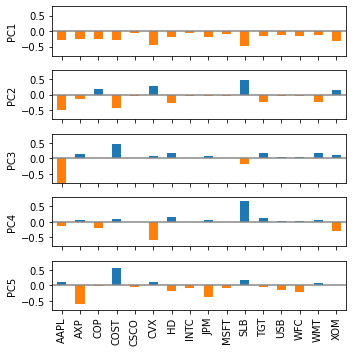

In [10]:
maxPC = 1.01 * loadings.loc[0:5, :].abs().to_numpy().max()

f, axes = plt.subplots(5, 1, figsize=(5, 5), sharex=True)

for i, ax in enumerate(axes):
    pc_loadings = loadings.loc[i, :]
    colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]
    ax.axhline(color='#888888')
    pc_loadings.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'PC{i+1}')
    ax.set_ylim(-maxPC, maxPC)

plt.tight_layout()
plt.show()

The loadings for the first principal component have the same sign: this is typical for data in which all the columns share a common factor (in this case, the overall stock market trend). The second component captures the price changes of energy stocks as compared to the other stocks. The third component is primarily a contrast in the movements of Apple and CostCo. The fourth component contrasts the movements of Schlumberger (SLB) to the other energy stocks. Finally, the fifth component is mostly dominated by financial companies.

### How Many Components to Choose?
If your goal is to reduce the dimension of the data, you must decide how many principal components to select. The most common approach is to use an ad hoc rule to select the components that explain “most” of the variance. You can do this visually through the screeplot. Alternatively, you could select the top components such that the cumulative variance exceeds a threshold, such as 80%. Also, you can inspect the loadings to determine if the component has an intuitive interpretation. Cross-validation provides a more formal method to select the number of significant components.

## Correspondence Analysis
Correspondence analysis is used mainly for graphical analysis of low-dimensional categorical data and is not used in the same way that PCA is for dimension reduction as a preparatory step with big data.


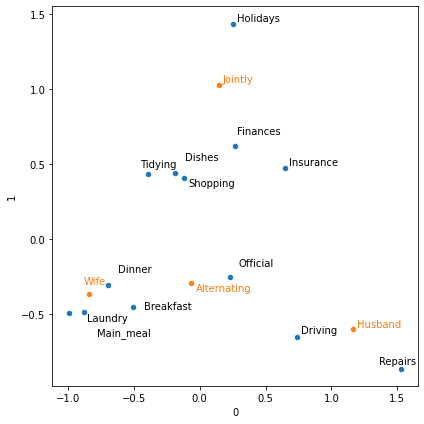

In [12]:
from adjustText import adjust_text

housetasks = pd.read_csv(HOUSE_TASKS_CSV, index_col=0)

ca = prince.CA(n_components=2)
ca = ca.fit(housetasks)

ax = ca.row_coordinates(housetasks).plot.scatter(x=0, y=1, figsize=(6,6))
ca.column_coordinates(housetasks).plot.scatter(x=0, y=1, ax=ax, c='C1')
texts = []
for idx, row in ca.row_coordinates(housetasks).iterrows():
    texts.append(plt.text(row[0], row[1], idx))
for idx, row in ca.column_coordinates(housetasks).iterrows():
    texts.append(plt.text(row[0], row[1], idx, color='C1'))
adjust_text(texts, only_move={'points':'y', 'texts':'y'}) 
plt.tight_layout()
plt.show()

The output (after some matrix algebra) is a biplot—a scatterplot with axes scaled (and with percentages indicating how much variance is explained by that dimension). The meaning of the units on the axes is not intuitively connected to the original data, and the main value of the scatterplot
is to illustrate graphically variables that are associated with one another (by proximity
on the plot).

## K-Means Clustering

- **Cluster**
- **Cluster mean**
- **K**

K-means divides the data into K clusters by minimizing the sum of the squared distances of each record to the *mean* of its assigned cluster. This is referred to as the *within-cluster sum of squares or within-cluster SS*.

## A Simple Example

Start by considering a data set with n records and just two variables, x and y. Suppose we want to split the data into $K = 4$ clusters. This means assigning each record $(x_i, y_i)$ to a cluster k. Given an assignment of $n_k$ records to cluster k, the center of the cluster $(\bar{x}_k, \bar{y}_k)$ is the mean of the points in the cluster: 

$$
\bar{x}_k = \frac{1}{n_k}\sum_{i]in \text{Cluster }k} x_i
$$

$$
\bar{y}_k = \frac{1}{n_k}\sum_{i]in \text{Cluster }k} y_i
$$

The sum of squares within a cluster is given by:

$$
SS_k = \sum_{i\in\text{Cluster }k} (x_i-\bar{x}_k)^2 + (y_i-\bar{y}_k)^2
$$

K-means finds the assignment of records that minimizes within-cluster sum of squares across all four clusters $SS_1+SS_2+SS_3+SS_4$

Suppose we want to divide daily stock returns into four groups. K-means clustering can be used to separate the data into the best groupings. Note that daily stock returns are reported in a fashion that is, in effect, standardized, so we do not need to normalize the data.

In [20]:

df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
kmeans = KMeans(n_clusters=4).fit(df)
df['cluster'] = kmeans.labels_
print(df.head())

                 XOM       CVX  cluster
2011-01-03  0.736805  0.240681        1
2011-01-04  0.168668 -0.584516        0
2011-01-05  0.026631  0.446985        1
2011-01-06  0.248558 -0.919751        0
2011-01-07  0.337329  0.180511        1


In [21]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['XOM', 'CVX'])
print(centers)

        XOM       CVX
0 -0.328125 -0.564848
1  0.242519  0.336479
2 -1.137958 -1.746642
3  0.960948  1.376572


Clusters 0 and 2 represent “down” markets, while clusters 1 and 3 represent “up markets.”

Note that K-means will assign records to clusters, even if those clusters are not well separated (which can be useful if you need to optimally divide records into groups).

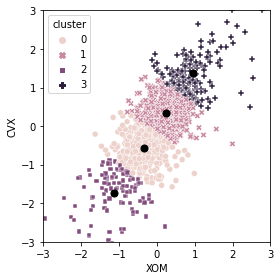

In [22]:
fig, ax = plt.subplots(figsize=(4, 4))
ax = sns.scatterplot(x='XOM', y='CVX', hue='cluster', style='cluster', 
                     ax=ax, data=df)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
centers.plot.scatter(x='XOM', y='CVX', ax=ax, s=50, color='black')

plt.tight_layout()
plt.show()

## K-Means Algorithm

While the exact solution to K-means is computationally very difficult, heuristic algorithms provide an efficient way to compute a locally optimal solution.

The algorithm starts with a user-specified K and an initial set of cluster means and then iterates the following steps:

1. Assign each record to the nearest cluster mean as measured by squared distance.
2. Compute the new cluster means based on the assignment of records.

The algorithm converges when the assignment of records to clusters does not change. Since this algorithm isn’t guaranteed to find the best possible solution, it is recommended to run the algorithm several times using different random samples to initialize the algorithm.

The s`cikit-learn` algorithm is repeated 10 times by default (`n_init`). The argument `max_iter` (default 300) can be used to control the number of iterations:

In [24]:
syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP', 
               'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST'])
top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]
kmeans = KMeans(n_clusters=5).fit(top_sp)

## Interpreting the Clusters

An important part of cluster analysis can involve the interpretation of the clusters. The two most important outputs from `kmeans` are the sizes of the clusters and the cluster means. 

In [25]:
from collections import Counter
print(Counter(kmeans.labels_))

Counter({0: 293, 4: 283, 3: 267, 2: 182, 1: 106})


The cluster sizes are relatively balanced. Imbalanced clusters can result from distant outliers, or from groups of records very distinct from the rest of the data—both may warrant further inspection.

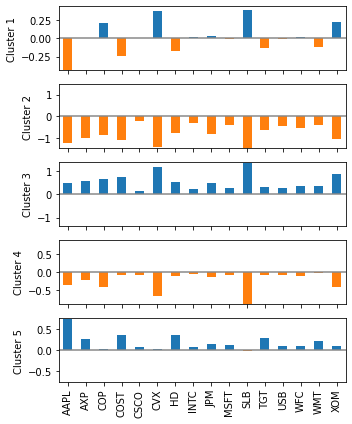

In [26]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=syms)

f, axes = plt.subplots(5, 1, figsize=(5, 6), sharex=True)
for i, ax in enumerate(axes):
    center = centers.loc[i, :]
    maxPC = 1.01 * np.max(np.max(np.abs(center)))
    colors = ['C0' if l > 0 else 'C1' for l in center]
    ax.axhline(color='#888888')
    center.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'Cluster {i + 1}')
    ax.set_ylim(-maxPC, maxPC)

plt.tight_layout()
plt.show()

The resulting plot reveals the nature of each cluster. For example, clusters 2 and 3 correspond to days on which the market is down and up, respectively. Clusters 5 and 4 are characterized by up-market days for consumer stocks and down-market days for energy stocks, respectively. Finally, cluster 1 captures the days in which energy stocks were up and consumer stocks were down.

**Note:**

The plot of cluster means is similar in spirit to looking at the load‐
ings for principal components analysis (PCA). A major distinction is that
unlike with PCA, the sign of the cluster means is meaningful. PCA
identifies principal directions of variation, whereas cluster analysis
finds groups of records located near one another.

## Selecting the Number of Clusters

The K-means algorithm requires that you specify the number of clusters K. In the absence of a cluster number dictated by practical or managerial considerations, a statistical approach could be used. There is no single standard method to find the “best” number of clusters.

A common approach, called the *elbow method*, is to identify when the set of clusters explains “most” of the variance in the data. Adding new clusters beyond this set contributes relatively little in the variance explained. The elbow is the point where the cumulative variance explained flattens out after rising steeply, hence the name of the method.

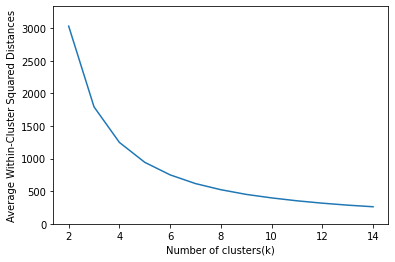

In [32]:
inertia = []
for n_clusters in range(2, 15):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(top_sp)
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(2, 15), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)

plt.show()

In evaluating how many clusters to retain, perhaps the most important test is this:
- How likely are the clusters to be replicated on new data? 
- Are the clusters interpretable?
- Do they relate to a general characteristic of the data?
- Do they just reflect a specific instance? 

You can assess this, in part, using cross-validation.

## Hierarchical Clustering

Hierarchical clustering allows the user to visualize the effect of specifying different numbers of clusters. It is more sensitive in discovering outlying or aberrant groups or records. Hierarchical clustering also lends itself to an intuitive graphical display, leading to easier interpretation of the clusters.

Important key terms:
- **Dendrogram**
- **Distance**
- **Dissimilarity**

Hierarchical clustering’s flexibility comes with a cost, and hierarchical clustering does not scale well to large data sets with millions of records. Indeed, most of the applications of hierarchical clustering are focused on relatively small data sets.

## A Simple Example

Hierarchical clustering works on a data set with n records and p variables and is based on two basic building blocks:

- A distance metric $d_{i,j}$ to measure the distance between two records i and j.
- A dissimilarity metric $D_{A, B}$ to measure the difference between two clusters A and B based on the distances $d_{i,j}$ between the members of each cluster.

In [33]:
syms1 = ['AAPL', 'AMZN', 'AXP', 'COP', 'COST', 'CSCO', 'CVX', 'GOOGL', 'HD', 
         'INTC', 'JPM', 'MSFT', 'SLB', 'TGT', 'USB', 'WFC', 'WMT', 'XOM']
df = sp500_px.loc[sp500_px.index >= '2011-01-01', syms1].transpose()

Z = linkage(df, method='complete')
print(Z.shape)

(17, 4)


## The Dendrogram

The leaves of the tree correspond to the records. The length of the branch in the tree indicates the degree of dissimilarity between corresponding clusters. The returns for Google and Amazon are quite dissimilar to one another and to the returns for the other stocks. The oil stocks (SLB, CVX, XOM, COP) are in their own cluster, Apple (AAPL) is by itself, and the rest are similar to
one another

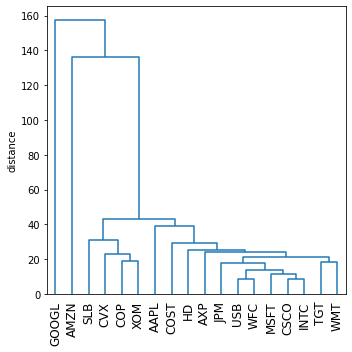

In [34]:
fig, ax = plt.subplots(figsize=(5, 5))
dendrogram(Z, labels=list(df.index), color_threshold=0)
plt.xticks(rotation=90)
ax.set_ylabel('distance')

plt.tight_layout()
plt.show()

In [38]:
memb = fcluster(Z, 4, criterion='maxclust')
memb = pd.Series(memb, index=df.index)
for key, item in memb.groupby(memb):
    print(f"{key} : {', '.join(item.index)}")

1 : COP, CVX, SLB, XOM
2 : AAPL, AXP, COST, CSCO, HD, INTC, JPM, MSFT, TGT, USB, WFC, WMT
3 : AMZN
4 : GOOGL


The number of clusters to extract is set to 4, and you can see that Google and Amazon each belong to their own cluster. The oil stocks all belong to another cluster. The remaining stocks are in the fourth cluster.

## The Agglomerative Algorithm

The agglomerative algorithm begins with each record constituting its own single-record cluster and then builds up larger and larger clusters. 

For each pair of records $(x_1, x_2,...,x_p)$ and $(y_1, y_2,...,y_p)$, we measure the distance between the two records, $d_{x,y}$, using a distance metric. We now turn to inter-cluster distance. Consider two clusters A and B, each with a distinctive set of records, $A = (a_1, a_2,...,a_m)$ and $B = (b_1, b_2,...,b_q)$. We can measure the dissimilarity between the clusters $D(A, B)$ by using the distances between the members of A and the members of B.

One measure of dissimilarity is the *complete-linkage* method, which is the maximum distance across all pairs of records between A and B:

$$
D(A,B) = \max d(a_i, b_j) \text{ for all pairs } i,j
$$

This defines the dissimilarity as the biggest difference between all pairs. The main steps of the agglomerative algorithm are:

1. Create an initial set of clusters with each cluster consisting of a single record for all records in the data.
2. Compute the dissimilarity $D(C_k, C_l)$ between all pairs of clusters $k,l$.
3. Merge the two clusters $C_k$ and $C_l$ that are least dissimilar as measured by $D(C_k, C_l)$.
4. If we have more than one cluster remaining, return to step 2. Otherwise, we are done.

## Measures of Dissimilarity

There are four common measures of dissimilarity: *complete linkage*, *single linkage*, *average linkage*, and *minimum variance*. The
complete linkage method defined earlier tends to produce clusters with members that are similar. The single linkage method is the minimum distance between the records in two clusters:

$$
D(A,B) = \min d(a_i, b_j) \text{ for all pairs } i,j
$$

This is a “greedy” method and produces clusters that can contain quite disparate elements.  The average linkage method is the average of all distance pairs and represents a compromise between the single and complete linkage methods. Finally, the minimum variance method, also referred to as Ward’s method, is similar to K-means since it minimizes the within-cluster sum of squares.

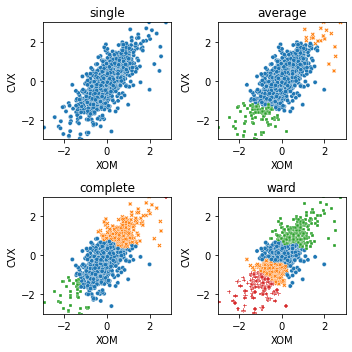

In [39]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))
for i, method in enumerate(['single', 'average', 'complete', 'ward']):
    ax = axes[i // 2, i % 2]
    Z = linkage(df, method=method)
    colors = [f'C{c+1}' for c in fcluster(Z, 4, criterion='maxclust')]
    ax = sns.scatterplot(x='XOM', y='CVX', hue=colors, style=colors,
                         size=0.5, ax=ax, data=df, legend=False)

    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_title(method)

plt.tight_layout()
plt.show()

## Model-Based Clustering

Clustering methods such as hierarchical clustering and K-means are based on heuristics and rely primarily on finding clusters whose members are close to one another, as measured directly with the data (no probability model involved). In the past 20 years, significant effort has been devoted to developing *model-based clustering* methods.

### Multivariate Normal Distribution

The most widely used model-based clustering methods rest on the multivariate normal distribution.  The multivariate normal distribution is a generalization of the normal distribution to a set of p variables $X_1,X_2,...,X_p$. The distribution is defined by a set of means $\mu = \mu_1, \mu_2,...,\mu_p$ and a covariance matrix $\sum$. The covariance matrix $\sum$ consists of p variances $\sigma = \sigma_1^2, \sigma_2^2,...,\sigma_P^2$ and covariances $\sigma_{i,j}$ for all pairs of variables $i\neq j$. With the variables put along the rows and duplicated along the columns, the matrix looks like this:

$$
\sum = \begin{bmatrix}
 \sigma_1^2 & \sigma_{1,2} & \dots & \sigma_{1,2}\\
 \sigma_{2,1} & \sigma_2^2  & \dots & \sigma_{2,p}\\
 \vdots & \vdots & \ddots & \vdots\\
 \sigma_{p,1}& \sigma_{p,2} & \dots & \sigma_p^2 \\
\end{bmatrix}
$$

Note that the covariance matrix is symmetric around the diagonal from upper left to lower right. Since $\sigma_{j,i}=\sigma_{i,j}$ there are only $\frac{p(p-1)}{2}$ covariance terms.  In total, the covariance matrix has $\frac{p(p-1)}{2}+p$ parameters. The distribution is denoted by:

$$
(X_1,X_2,...,X_p) \sim  N_p(\mu, \sigma)
$$

This is a symbolic way of saying that the variables are all normally distributed, and the overall distribution is fully described by the vector of variable means and the covariance matrix.

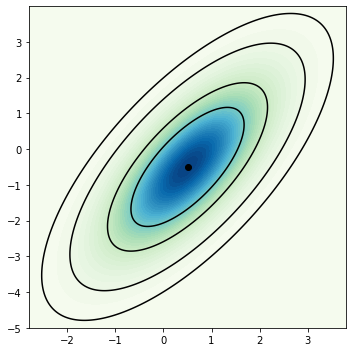

In [40]:
mean = [0.5, -0.5]
cov = [[1, 1], [1, 2]]
probability = [.5, .75, .95, .99]
def probLevel(p):
    D = 1
    return (1 - p) / (2 * math.pi * D)
levels = [probLevel(p) for p in probability]

fig, ax = plt.subplots(figsize=(5, 5))

x, y = np.mgrid[-2.8:3.8:.01, -5:4:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal(mean, cov)


CS = ax.contourf(x, y, rv.pdf(pos), cmap=cm.GnBu, levels=50)
ax.contour(CS, levels=levels, colors=['black'])
ax.plot(*mean, color='black', marker='o')


plt.tight_layout()
plt.show()

This shows the probability contours for a multivariate normal distribution for
two variables X and Y.

### Mixtures of Normals

The key idea behind model-based clustering is that each record is assumed to be distributed as one of K multivariate normal distributions, where K is the number of clusters. Each distribution has a different mean $\mu$ and covariance matrix $\sum$. For example, if you have two variables, X and Y, then each row  $(X_i, Y_i)$ is modeled as having bee sampled from one of K multivariate normal distributions

$$
N(\mu_1, \sigma_1), N(\mu_2, \sigma_2),..., N(\mu_K, \sigma_K)
$$

In [41]:

df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
mclust = GaussianMixture(n_components=2).fit(df)
print(mclust.bic(df))

4589.928857318638


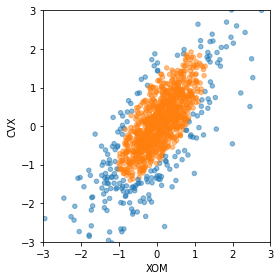

In [42]:
fig, ax = plt.subplots(figsize=(4, 4))
colors = [f'C{c}' for c in mclust.predict(df)]
df.plot.scatter(x='XOM', y='CVX', c=colors, alpha=0.5, ax=ax)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

plt.tight_layout()
plt.show()

In [43]:
print('Mean')
print(mclust.means_)
print('Covariances')
print(mclust.covariances_)

Mean
[[-0.05031426 -0.21161823]
 [ 0.07246995  0.10494619]]
Covariances
[[[0.97123064 0.97764343]
  [0.97764343 1.67233845]]

 [[0.26822676 0.27562091]
  [0.27562091 0.51679853]]]


The goal of model-based clustering is to find the best-fitting set of multivariate normal distributions. The stock data appears to have a normal looking shape. In fact, though, stock returns have a longer-tailed distribution than a normal distribution. To handle this, mclust fits a distribution to the bulk of the data but then fits a second distribution with a bigger variance.

### Selecting the Number of Clusters

Unlike K-means and hierarchical clustering, mclust automatically selects the number of clusters in R (in this case, two). It does this by choosing the number of clusters for which the Bayesian Information Criteria (BIC) has the largest value (BIC is similar to AIC).

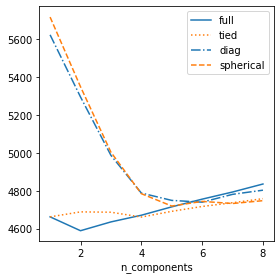

In [44]:
results = []
covariance_types = ['full', 'tied', 'diag', 'spherical']
for n_components in range(1, 9):
    for covariance_type in covariance_types:
        mclust = GaussianMixture(n_components = n_components, warm_start=True,
                                 covariance_type = covariance_type)
        mclust.fit(df)
        results.append({
            'bic': mclust.bic(df),
            'n_components': n_components,
            'covariance_type': covariance_type,
        })
        
results = pd.DataFrame(results)

colors = ['C0', 'C1', 'C2', 'C3']
styles = ['C0-','C1:','C0-.', 'C1--']

fig, ax = plt.subplots(figsize=(4, 4))
for i, covariance_type in enumerate(covariance_types):
    subset = results.loc[results.covariance_type == covariance_type, :]
    subset.plot(x='n_components', y='bic', ax=ax, label=covariance_type, 
                kind='line', style=styles[i]) # , color=colors[i])

plt.tight_layout()
plt.show()

Model-based clustering techniques do have some limitations. The methods require an underlying assumption of a model for the data, and the cluster results are very dependent on that assumption. The computations requirements are higher than even hierarchical clustering, making it difficult to scale to large data. Finally, the algorithm is more sophisticated and less accessible than that of other methods.

For example, with the personal loan data, the variables have widely different units and magnitude. Some variables have relatively small values (e.g., number of years employed), while others have very large values (e.g., loan amount in dollars). If the data is not scaled, then the PCA, K-means, and other clustering methods will be dominated by the variables with large values and ignore the variables with small values.

## Scaling and Categorical Variables

Important key terms:
- **Scaling**
- **Normalization**
- **Gower’s distance**

### Scaling the Variables

In [46]:
loan_data = pd.read_csv(LOAN_DATA_CSV)
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)
defaults = loan_data.loc[loan_data['outcome'] == 'default',]

columns = ['loan_amnt', 'annual_inc', 'revol_bal', 'open_acc', 
           'dti', 'revol_util']

df = defaults[columns]
kmeans = KMeans(n_clusters=4, random_state=1).fit(df)
counts = Counter(kmeans.labels_)

centers = pd.DataFrame(kmeans.cluster_centers_, columns=columns)
centers['size'] = [counts[i] for i in range(4)]
print(centers)

      loan_amnt     annual_inc     revol_bal   open_acc        dti  \
0  18275.132345   83354.634595  19635.189254  11.664373  16.774586   
1  21852.701005  165407.730318  38907.295645  12.597152  13.466876   
2  10591.893792   42453.058692  10268.048598   9.583820  17.713563   
3  22570.192308  489783.403846  85161.346154  13.326923   6.907500   

   revol_util   size  
0   62.258588   7543  
1   63.634900   1194  
2   58.111226  13882  
3   59.651923     52  


The variables annual_inc and revol_bal dominate the clusters, and the clusters have very different sizes. Cluster 3 has only 52 members with comparatively high income and revolving credit balance.

A common approach to scaling the variables is to convert them to z-scores by
subtracting the mean and dividing by the standard deviation.

In [48]:
scaler = preprocessing.StandardScaler()
df0 = scaler.fit_transform(df * 1.0)

kmeans = KMeans(n_clusters=4, random_state=1).fit(df0)
counts = Counter(kmeans.labels_)

centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                       columns=columns)
centers['size'] = [counts[i] for i in range(4)]
print(centers)

      loan_amnt     annual_inc     revol_bal   open_acc        dti  \
0  10499.824632   51070.958451  11629.172535   7.511129  15.965747   
1  10315.255666   53468.181307   6032.616033   8.637385  11.255855   
2  25920.260952  116308.326663  32827.641428  12.389941  16.204021   
3  13420.700048   55844.852918  16370.832021  14.334512  24.189881   

   revol_util  size  
0   77.806693  7405  
1   31.000342  5339  
2   66.172004  3701  
3   59.227862  6226  


The cluster sizes are more balanced, and the clusters are not dominated by
annual_inc and revol_bal, revealing more interesting structure in the data. Note
that the centers are rescaled to the original units in the preceding code. If we had left them unscaled, the resulting values would be in terms of z-scores and would therefore be less interpretable.

**Note:**

Scaling is also important for PCA. Using the z-scores is equivalent
to using the correlation matrix (see “Correlation” on page 30)
instead of the covariance matrix in computing the principal com‐
ponents.

### Dominant Variables

Even in cases where the variables are measured on the same scale and accurately
reflect relative importance (e.g., movement to stock prices), it can sometimes be useful to rescale the variables.

Suppose we add Google (GOOGL) and Amazon (AMZN) to the analysis in Inter‐
preting Principal Components.

The screeplot displays the variances for the top principal components. In this case, the screeplot reveals that the variances of the first and second components are much larger than the others. This often indicates that one or two variables dominate the loadings.

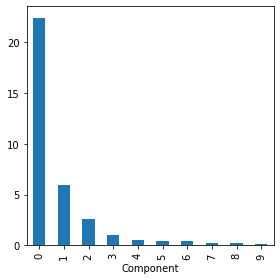

In [49]:
syms = ['GOOGL', 'AMZN', 'AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 
        'SLB', 'COP', 'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST']
top_sp1 = sp500_px.loc[sp500_px.index >= '2005-01-01', syms]

sp_pca1 = PCA()
sp_pca1.fit(top_sp1)

explained_variance = pd.DataFrame(sp_pca1.explained_variance_)
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(4, 4))
ax.set_xlabel('Component')

plt.tight_layout()
plt.show()

In [50]:
loadings = pd.DataFrame(sp_pca1.components_[0:2, :], 
                        columns=top_sp1.columns)
print(loadings.transpose())

              0         1
GOOGL -0.857310  0.477873
AMZN  -0.444728 -0.874149
AAPL  -0.071627 -0.020802
MSFT  -0.036002 -0.006204
CSCO  -0.029205 -0.003045
INTC  -0.026666 -0.006069
CVX   -0.089548 -0.037420
XOM   -0.080336 -0.020511
SLB   -0.110218 -0.030356
COP   -0.057739 -0.024117
JPM   -0.071228 -0.009244
WFC   -0.053228 -0.008597
USB   -0.041670 -0.005952
AXP   -0.078907 -0.024027
WMT   -0.040346 -0.007141
TGT   -0.063659 -0.024662
HD    -0.051412 -0.032922
COST  -0.071403 -0.033826


To handle this situation, you can either include them as is, rescale the variables, or exclude the dominant variables from the analysis and handle them separately. There is no “correct” approach, and the treatment depends on the application.

## Categorical Data and Gower's Distance

Currently not available in any of the standard packages. However work is in progress to add it to scikit-learn. We will update this notebook once it becomes available

https://github.com/scikit-learn/scikit-learn/pull/9555/

###############################################################
## Figure 7-13: Categorical data and Gower's distance

x <- loan_data[1:5, c('dti', 'payment_inc_ratio', 'home_', 'purpose_')]
x

daisy(x, metric='gower')

set.seed(301)
df <- loan_data[sample(nrow(loan_data), 250),
                c('dti', 'payment_inc_ratio', 'home_', 'purpose_')]
d = daisy(df, metric='gower')
hcl <- hclust(d)
dnd <- as.dendrogram(hcl)

png(filename=file.path(PSDS_PATH, 'figures', 'psds_0713.png'), width = 4, height=4, units='in', res=300)
par(mar=c(0,5,0,0)+.1)
plot(dnd, leaflab='none', ylab='distance')
dev.off()

dnd_cut <- cut(dnd, h=.5)
df[labels(dnd_cut$lower[[1]]),]


###############################################################
Problems in clustering with mixed data types
df <- model.matrix(~ -1 + dti + payment_inc_ratio + home_ + pub_rec_zero, data=defaults)
df0 <- scale(df)
km0 <- kmeans(df0, centers=4, nstart=10)
centers0 <- scale(km0$centers, center=FALSE, scale=1/attr(df0, 'scaled:scale'))
round(scale(centers0, center=-attr(df0, 'scaled:center'), scale=FALSE), 2)

In [51]:

x = defaults[['dti', 'payment_inc_ratio', 'home_', 'purpose_']].loc[0:4, :]
print(x)

     dti  payment_inc_ratio home_            purpose_
0   1.00            2.39320  RENT      major_purchase
1   5.55            4.57170   OWN      small_business
2  18.08            9.71600  RENT               other
3  10.08           12.21520  RENT  debt_consolidation
4   7.06            3.90888  RENT               other


## Problems with Clustering Mixed Data

K-means and PCA are most appropriate for continuous variables. For smaller data
sets, it is better to use hierarchical clustering with Gower’s distance.

K-means and PCA are most appropriate for continuous variables. For smaller data
sets, it is better to use hierarchical clustering with Gower’s distance. In principle, there is no reason why K-means can’t be applied to binary or categorical data. You would usually use the “one hot encoder” representation to convert the categorical data to numeric values. In practice, however, using K-means and PCA with binary data can be difficult.

If the standard z-scores are used, the binary variables will dominate the definition of the clusters. This is because 0/1 variables take on only two values, and K-means can obtain a small within-cluster sum-of-squares by assigning all the records with a 0 or 1 to a single cluster.

In [53]:
columns = ['dti', 'payment_inc_ratio', 'home_', 'pub_rec_zero']
df = pd.get_dummies(defaults[columns])

scaler = preprocessing.StandardScaler()

df0 = scaler.fit_transform(df * 1.0)
kmeans = KMeans(n_clusters=4, random_state=1).fit(df0)
centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                       columns=df.columns)
print(centers)

         dti  payment_inc_ratio  pub_rec_zero  home__MORTGAGE     home__OWN  \
0  16.992128           9.105395  1.000000e+00    9.436896e-15  3.344547e-15   
1  17.456244           8.422914  1.000000e+00    1.000000e+00  1.887379e-15   
2  16.504955           8.064247  9.325873e-15    5.156600e-01  1.526557e-16   
3  17.197993           9.266666  9.179025e-01   -2.331468e-15  1.000000e+00   

     home__RENT  
0  1.000000e+00  
1  1.643130e-14  
2  4.843400e-01  
3 -2.220446e-15  


The top four clusters are essentially proxies for the different levels of the factor variables. To avoid this behavior, you could scale the binary variables to have a smaller variance than other variables. Alternatively, for very large data sets, you could apply clustering to different subsets of data taking on specific categorical values. For example, you could apply clustering separately to those loans made to someone who has a mortgage, owns a home outright, or rents.